In [220]:
import os
import json
import csv
import pandas as pd
import random, string, re, collections
import numpy as np
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import torch
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

from adjustText import adjust_text
import colorsys

from plot_utilities import *
from importlib import reload
# reload(plot_utilities)

In [3]:
# compute the rank of each role per dataset 
def get_dataset_acc_mean_rank(df, attribute='merged_cate'):
    mean_df = df.groupby([attribute, 'dataset'])['accuracy'].mean().reset_index()
    mean_df['rank'] = mean_df.groupby('dataset')['accuracy'].rank(ascending=False)
    
    mean_rank_df = mean_df.groupby(attribute)['rank'].mean()
    var_rank = mean_df.groupby(attribute)['rank'].var()
    
    rank_df = pd.DataFrame({
        'mean_rank': mean_rank_df,
        'variance_of_rank': var_rank}).reset_index()
    return mean_df, rank_df

def get_role_acc_mean_rank(df):
    mean_df = df.groupby(['role', 'merged_cate','dataset', 'question', 'option1', 'option2', 'option3', 'option4'])['accuracy'].mean().reset_index()
    mean_df['rank'] = mean_df.groupby('role')['accuracy'].rank(ascending=False)
    return mean_df

def get_ques_prompt_acc(role_df):
    return role_df.groupby(['prompt', 'question', 'dataset', 'full_question'])['accuracy'].mean().reset_index()


In [70]:
def drop_duplicate_ans(identifier_col, ans_df):
    return ans_df[identifier_col].drop_duplicates()

# Load data

In [364]:
ques_df = pd.read_csv("../data/final_mmlu_sample_ques.csv")

role_df_path = "../data/final-final-role-cate.csv"
role_df = pd.read_csv(role_df_path)

classification_question_split = pd.read_csv("../data/question_split.csv")
test_ques_df = classification_question_split[classification_question_split['split'] == 'test']
train_ques_df = classification_question_split[classification_question_split['split'] == 'train']

In [5]:
model_path_dic = {'flan': "../data/mmlu_role_ans/flan_xxl_result_full.csv",
             'llama': "../data/llama2_all_result.csv",
             'opt': "../data/mmlu_role_ans/opt_1.3b_result_full.csv"}

In [33]:
model_ans_dic = {}
for model_name, ans_path in model_path_dic.items():
    model_ans_dic[model_name] = pd.read_csv(ans_path)

In [9]:
model_ans_dic['llama'].columns

Index(['role', 'prompt', 'question', 'full_prompt', 'answer', 'option1',
       'option2', 'option3', 'option4', 'opt', 'Unnamed: 0', 'dataset',
       'full_question', 'split', 'true_option', 'index', 'accuracy'],
      dtype='object')

In [34]:
# pre-process answers
identifier_col = ['full_prompt', 'full_question', 'role', 'merged_cate', 'answer', 'prompt', 
                  'question', 'option1', 'option2', 'option3', 'option4', 'dataset', 'accuracy']

for model_name, ans_df in model_ans_dic.items():
    if model_name == 'flan':
        model_ans_dic[model_name] = pd.merge(ans_df, ques_df[['question_id', 'option1', 'option2', 'option3', 'option4']], how='left').drop('merged_cate', axis=1).merge(role_df[['role', 'merged_cate', 'mmlu']], how='left')
        model_ans_dic[model_name] = model_ans_dic[model_name].merge(classification_question_split[['question_id', 'dataset', 'question', 'full_question']], on=['question_id', 'dataset', 'question'], how='left')
        model_ans_dic[model_name]['prompt'] = model_ans_dic[model_name]['prompt'].str.replace('{relationship}. {question_text}', '{role}.')
        model_ans_dic[model_name] = drop_duplicate_ans(identifier_col, model_ans_dic[model_name])
    elif model_name == 'llama':
        model_ans_dic[model_name] = pd.merge(ans_df, role_df[['role', 'merged_cate']], how='left')
        model_ans_dic[model_name] = drop_duplicate_ans(identifier_col, model_ans_dic[model_name])
    elif model_name == 'opt':
        model_ans_dic[model_name] = model_ans_dic[model_name].drop('merged_cate', axis=1).merge(role_df[['role', 'merged_cate', 'mmlu']], how='left')
        model_ans_dic[model_name] = pd.merge(model_ans_dic[model_name], 
                                             classification_question_split[['dataset', 'question','option1', 'option2', 'option3', 'option4','full_question']], 
                                             on=['dataset', 'question','option1', 'option2', 'option3', 'option4'], 
                                             how='left')
        model_ans_dic[model_name] = drop_duplicate_ans(identifier_col, model_ans_dic[model_name])
        

/tmp/ipykernel_1488078/573670061.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  model_ans_dic[model_name]['prompt'] = model_ans_dic[model_name]['prompt'].str.replace('{relationship}. {question_text}', '{role}.')


In [35]:
model_ans_dic['llama'].shape

(2209356, 13)

In [36]:
model_ans_dic['flan'].shape

(2284200, 13)

In [37]:
model_ans_dic['opt'].shape

(2192911, 13)

In [221]:
2284200/162/6

2350.0

# Process data

In [23]:
def process_model_results(model_ans_dic):
    results = {}
    for model_name, df in model_ans_dic.items():
        role_dataset_mean, role_dataset_rank = get_dataset_acc_mean_rank(df, 'role')
        rolecate_dataset_mean, rolecate_dataset_ranks = get_dataset_acc_mean_rank(df)
        
        role_mean_rank = get_role_acc_mean_rank(df)
        
        prompt_ques_mean = get_ques_prompt_acc(df[df['prompt'] != 'Control'])
        
        agg_rolecate_acc = df.groupby('merged_cate')['accuracy'].mean().sort_values(ascending=False).reset_index()

        # Storing results
        results[model_name] = {
            'role': {'dataset_mean': role_dataset_mean, 
                     'dataset_rank': role_dataset_rank, 
                     'mean': role_mean_rank},
            'rolecate': {'dataset_mean': rolecate_dataset_mean, 
                         'dataset_ranks': rolecate_dataset_ranks, 
                         'agg_mean':agg_rolecate_acc},
            'prompt_ques_mean': prompt_ques_mean,
        }
    return results

In [38]:
model_results_all = process_model_results(model_ans_dic)

In [39]:
model_results_all['flan'].keys()

dict_keys(['role', 'rolecate', 'prompt_ques_mean'])

In [40]:
# 4212/162=26 (162 roles over 26 datasets)
model_results_all['flan']['role']['dataset_mean'].shape

(4212, 4)

In [41]:
## Process the control data 
flan_control = pd.read_csv("../data/mmlu_invariant_ans/flan_t5_xxl_control.csv")
llama_ctrl_df = pd.read_csv("../data/mmlu_invariant_ans/llama2_7b_chat_control.csv")
opt_control = pd.read_csv("../data/mmlu_invariant_ans/opt_iml_max_1.3b_control.csv")

flan_control_full = pd.merge(flan_control[['dataset', 'question', 'answer']], 
                             ques_df[['dataset', 'question', 'true_option']], how='left'
flan_control_full['accuracy'] = (flan_control_full['answer'] == flan_control_full['true_option']).astype(int)

llama_control_full = pd.merge(llama_ctrl_df[['dataset', 'question', 'opt']], 
                             ques_df[['dataset', 'question', 'true_option']], how='left')
llama_control_full['accuracy'] = (llama_control_full['opt'] == llama_control_full['true_option']).astype(int)


opt_control['opt'] = opt_control['answer'].str.extract(r'\n\n### Response:(\d+)')
opt_control['opt'] = opt_control['opt'].fillna(0)
opt_control['opt'] = opt_control['opt'].astype(int)
opt_control_full = pd.merge(opt_control[['dataset', 'question', 'opt']], 
                             ques_df[['dataset', 'question', 'true_option']], how='left')
opt_control_full['accuracy'] = (opt_control_full['opt'] == opt_control_full['true_option']).astype(int)

flan_control_full['model'] = 'flan'
llama_control_full['model'] = 'llama'
opt_control_full['model'] = 'opt'

control_df = pd.concat([flan_control_full, 
                        llama_control_full[['dataset', 'question', 'true_option', 'accuracy','model']], 
                        opt_control_full[['dataset', 'question', 'true_option', 'accuracy','model']]])

model_control_mean = control_df.groupby('model')['accuracy'].mean().reset_index()

model_control_mean.rename(columns={'accuracy':'control'}, inplace=True)

In [466]:
model_ctrl_dic = {'flan': flan_control_full,
                 'llama': llama_control_full,
                 'opt': opt_control_full}

In [45]:
# control_df.to_csv("../data/control_result_all_models.csv", index=False)

In [44]:
model_control_mean

,model,control
0,flan,0.493036
1,llama,0.366494
2,opt,0.022284


In [42]:
overall_control_mean = model_control_mean['control'].mean()
overall_control_mean

0.2939381880886059

# Rank of roles (figure 2)

In [43]:
def map_rank_to_accuracy(rank, dataset, model_type):
    """
    Map a rank to its corresponding accuracy for a given model type ('llama' or 'flan').

    :param rank: The rank value to be mapped.
    :param dataset: The DataFrame containing rank and accuracy data.
    :param model_type: A string, either 'llama' or 'flan', indicating the model type.
    :return: The accuracy corresponding to the given rank.
    """
    if model_type == 'llama':
        rank_column = 'rank_llama'
        accuracy_column = 'accuracy_llama'
    elif model_type == 'flan':
        rank_column = 'rank_flan'
        accuracy_column = 'accuracy_flan'
    else:
        raise ValueError("Model type must be 'llama' or 'flan'.")

    # Find the closest rank in the dataset and return its corresponding accuracy
    nearest_rank_index = np.argmin(np.abs(dataset[rank_column] - rank))
    return dataset.iloc[nearest_rank_index][accuracy_column]

In [62]:
llama_role_acc = model_ans_dic['llama'].groupby('role')['accuracy'].mean().sort_values(ascending=False).reset_index()
flan_role_acc = model_ans_dic['flan'].groupby('role')['accuracy'].mean().sort_values(ascending=False).reset_index()


corr_role_df = llama_role_acc.merge(flan_role_acc, on='role', how='left', suffixes=('_llama', '_flan'))
corr_role_df['rank_llama'] = corr_role_df['accuracy_llama'].rank(ascending=False, method='average')
corr_role_df['rank_flan'] = corr_role_df['accuracy_flan'].rank(ascending=False, method='average')

spearman_corr, spearman_p_value = spearmanr(corr_role_df['rank_llama'], corr_role_df['rank_flan'])
pearson_corr, pearson_p_value = pearsonr(corr_role_df['accuracy_llama'], corr_role_df['accuracy_flan'])

print(f"Spearman rank correlation: {spearman_corr}, with a p-value of {spearman_p_value}")
print(f"Pearson correlation: {pearson_corr}, with a p-value of {pearson_p_value}")

Spearman rank correlation: 0.23910633213670615, with a p-value of 0.0021815400191146925
Pearson correlation: 0.1947131816865182, with a p-value of 0.01303121224432074


In [60]:
flan_role_acc.shape

(162, 2)

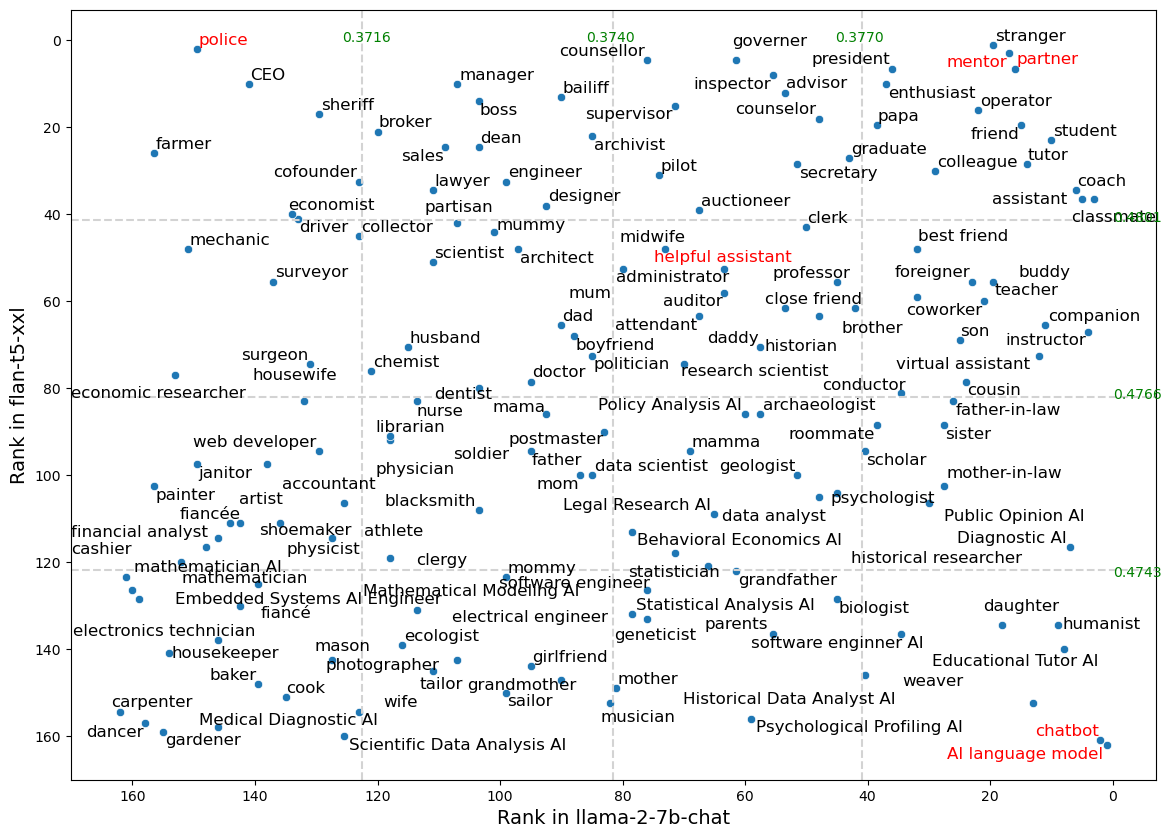

In [63]:
percentiles_x = np.percentile(corr_role_df['rank_llama'], [25, 50, 75])
percentiles_y = np.percentile(corr_role_df['rank_flan'], [25, 50, 75])

accuracy_percentiles_llama = [map_rank_to_accuracy(p, corr_role_df, 'llama') for p in percentiles_x]
accuracy_percentiles_flan = [map_rank_to_accuracy(p, corr_role_df, 'flan') for p in percentiles_y]

plt.figure(figsize=(14, 10))
sns.scatterplot(data=corr_role_df, x='rank_llama', y='rank_flan')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

hl_roles = ['mentor', 'partner', 'police', 'chatbot', 'AI language model', 'helpful assistant ']
texts = []
for i, point in corr_role_df.iterrows():
    highlight = point['rank_llama'] in percentiles_x or point['rank_flan'] in percentiles_y
    color = 'red' if point['role'] in hl_roles else 'black'
    texts.append(plt.text(point['rank_llama'], point['rank_flan'], point['role'], fontsize=12, color=color))


for p in percentiles_x:
    plt.axvline(x=p, color='lightgray', linestyle='--')

for p in percentiles_y:
    plt.axhline(y=p, color='lightgray', linestyle='--')

for i, percentile in enumerate(percentiles_x):
    plt.text(0, percentile, 
             f'{accuracy_percentiles_flan[i]:.4f}', va='center', ha='left', color='green')

for i, percentile in enumerate(percentiles_y):
    plt.text(percentile, 1, 
             f'{accuracy_percentiles_llama[i]:.4f}', ha='center', va='bottom', color='green')

adjust_text(texts)

plt.xlabel('Rank in llama-2-7b-chat', fontsize=14)
plt.ylabel('Rank in flan-t5-xxl', fontsize=14)


plt.grid(False)
# plt.savefig('../shared_data/figures/spearman_role_flan_llama.pdf', bbox_inches='tight')

plt.show()

# Occupation vs. interpersonal Roles (figure 3)

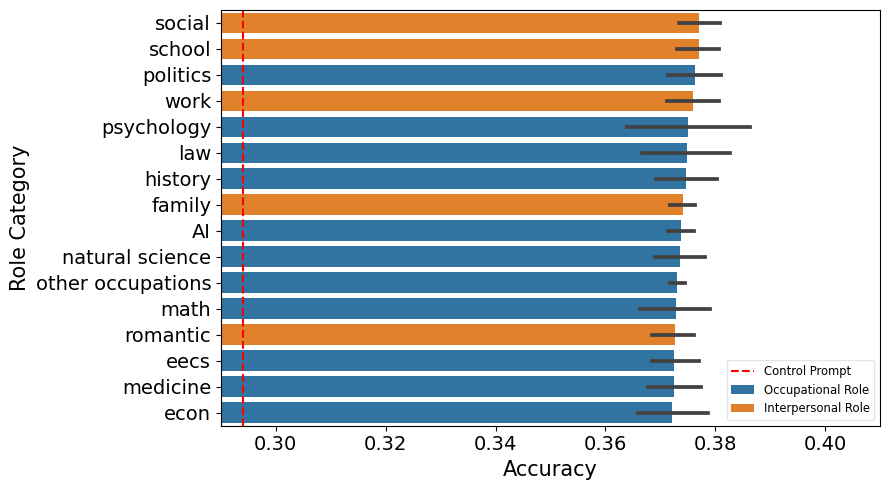

In [159]:
tdf_ = pd.concat([model_dic['role']['mean'] for model_dic in model_results_all.values()])
plot_rolecate_rank(tdf_, role_df, overall_control_mean)

# Perspective-taking Impact (figure 5)

In [66]:
prompt_map = {'You are talking to your {role}.' : 'interpersonal prompt',
              'Imagine you are talking to your {role}.': 'interpersonal prompt',
              'You are talking to {indefinite} {role}.': 'audience prompt',
              'Imagine you are talking to {indefinite} {role}.': 'audience prompt',
              'You are {indefinite} {role}.':'role prompt',
              'Imagine you are {indefinite} {role}.': 'role prompt'
             }

In [68]:
models = ['flan', 'opt', 'llama']
prompt_ques_all = pd.concat([model_results_all[m]['prompt_ques_mean'] for m in models])

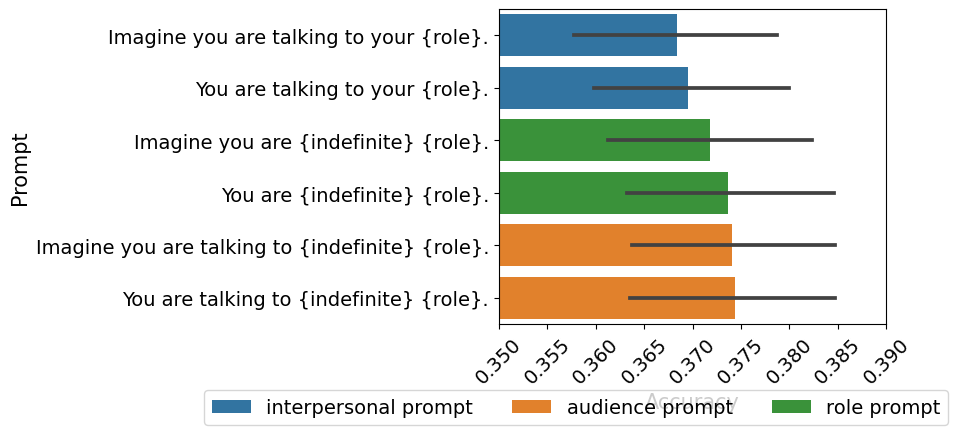

In [69]:
plot_acc_by_prompt(prompt_ques_all)

# In-domain vs. Out-domain role playing by domain (figure 4)

In [71]:
domain_dic = {'law': ['professional_law', 'international_law'],
             'medicine': ['clinical_knowledge', 'college_medicine', 'professional_medicine'],
             'eecs': ['electrical_engineering', 'college_computer_science', 'high_school_computer_science'],
             'math': ['high_school_statistics', 'college_mathematics', 'high_school_mathematics'],
             'politics': ['us_foreign_policy', 'high_school_government_and_politics'],
             'psychology': ['professional_psychology', 'high_school_psychology'],
             'natural science': ['college_physics', 'college_biology', 'high_school_physics',
                                'high_school_chemistry', 'college_chemistry', 'high_school_biology'],
             'econ': ['management', 'professional_accounting', 'econometrics', 'high_school_macroeconomics', 'high_school_microeconomics']}

def find_domain(dataset_val):
    for domain, datasets in domain_dic.items():
        if dataset_val in datasets:
            return domain
    return None

In [72]:
model_ans_dic.keys()
list(model_ans_dic.values())

dict_keys(['flan', 'llama', 'opt'])

In [82]:
for model_name, ans_df in model_ans_dic.items():
    model_ans_dic[model_name] = ans_df.assign(
        domain=ans_df['dataset'].apply(lambda x: find_domain(x)),
        in_domain=ans_df.apply(lambda row: 1 if find_domain(row['dataset']) == row['merged_cate'] else 0, axis=1)
    )


In [86]:
mmlu_cate =['psychology', 'politics', 'natural science', 'medicine', 'math', 'law', 'history', 'eecs', 'econ']

tdf = pd.concat(list(model_ans_dic.values()), axis=0)[lambda df: df['merged_cate'].isin(mmlu_cate)]
tdf.shape

(1444513, 15)

In [87]:
tdf.groupby(['dataset', 'role'])['accuracy'].mean().sort_values(ascending=False).reset_index().head(10)

,dataset,role,accuracy
0,high_school_psychology,data scientist,0.558889
1,high_school_psychology,politician,0.551667
2,high_school_psychology,software engineer,0.548333
3,high_school_psychology,physicist,0.546667
4,high_school_psychology,psychologist,0.545556
5,us_foreign_policy,historian,0.545297
6,high_school_psychology,Embedded Systems AI Engineer,0.544444
7,us_foreign_policy,historical researcher,0.543829
8,high_school_psychology,chemist,0.542778
9,high_school_psychology,data analyst,0.542778


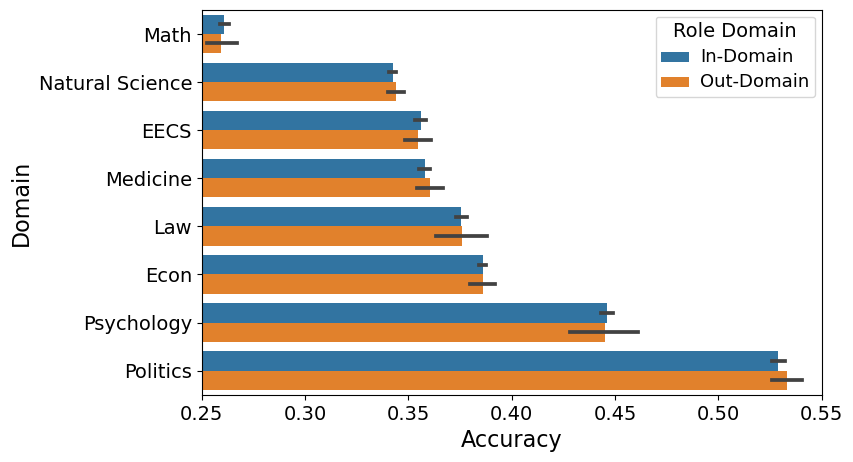

In [161]:
plot_domain_effect(tdf)

# Rank of Role Category between Flan and Llama (figure 6)

In [134]:
merge_rank_df, corr_df = calculate_correlations(model_results_all)

for key, value in corr_df.items():
    print(f"{key}: Correlation = {value[0]}, P-value = {value[1]}")

('llama', 'flan', 'spearman'): Correlation = 0.3235294117647059, P-value = 0.2215741250012429
('llama', 'flan', 'pearson'): Correlation = 0.34307190730671955, P-value = 0.1932988133927068
('llama', 'opt', 'spearman'): Correlation = 0.5764705882352941, P-value = 0.01941514038653157
('llama', 'opt', 'pearson'): Correlation = 0.49928510757649563, P-value = 0.04895449006495314


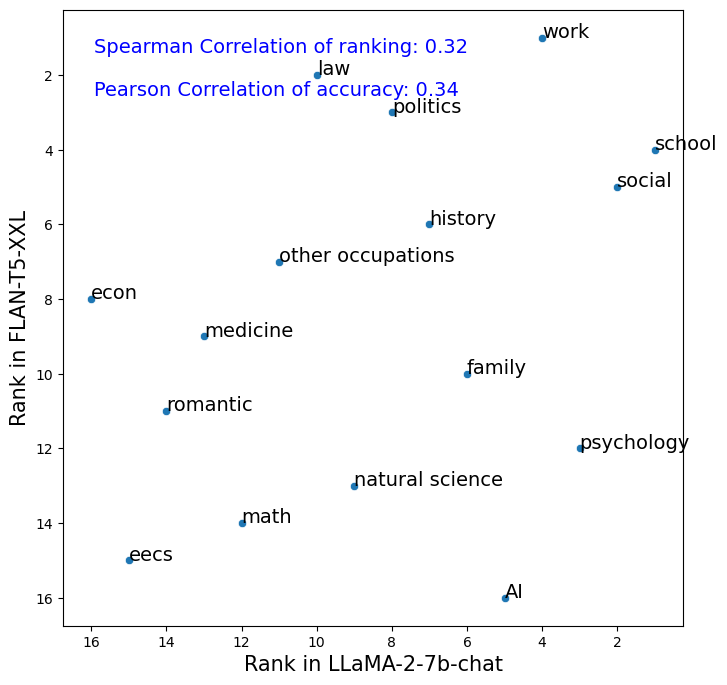

In [135]:
plot_rolecate_corr(merge_rank_df, corr_df, 'llama', 'flan', 'LLaMA-2-7b-chat', 'FLAN-T5-XXL')

# Hyponyms analysis (figure 7)

In [145]:
# column 'Base Word' is the base word of its hyponyms 
role_full = pd.read_csv("../shared_data/social-role-final.csv")
role_full.columns

Index(['role', 'N-gram Frequency (2018-2019)', 'Type', 'Base Word', 'rel cate',
       'mmlu cate'],
      dtype='object')

In [151]:
filtered_roles.columns

Index(['Base Word', 'role_x', 'num_hypo', 'role_y',
       'N-gram Frequency (2018-2019)', 'Type', 'rel cate', 'mmlu cate'],
      dtype='object')

In [152]:
grouped_words = role_full.groupby('Base Word')['role'].agg(list).reset_index()
filtered_base_words = grouped_words[grouped_words['role'].apply(lambda x: len(x) > 1)]
filtered_base_words['num_hypo'] = filtered_base_words['role'].apply(lambda x: len(x))
filtered_roles = role_full.merge(filtered_base_words[['Base Word']], on='Base Word', how='inner')

roles_multi_hyponym = pd.merge(filtered_roles, role_df[['role', 'merged_cate']], how='left')

models = ['flan', 'llama', 'opt']
hypo_data = []

for model in models:
    dataset_role_mean = model_results_all[model]['role']['dataset_mean']
    merged_data = pd.merge(roles_multi_hyponym, dataset_role_mean)
    merged_data['model'] = model
    hypo_data.append(merged_data)

multi_hypo_combined_df = pd.concat(hypo_data, ignore_index=True)
mean_rank_per_role_model = multi_hypo_combined_df.groupby(['role', 'model', 'Base Word'])['rank'].mean().reset_index()


/tmp/ipykernel_1488078/3170465976.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_base_words['num_hypo'] = filtered_base_words['role'].apply(lambda x: len(x))


In [153]:
mean_rank_per_role_model.groupby('Base Word')['rank'].mean().reset_index

<bound method Series.reset_index of Base Word
advisor       71.621795
boyfriend     88.365385
coworker      75.804487
father        76.179487
friend        72.338141
girlfriend    91.275641
mother        86.594017
parents       88.250000
partner       82.777778
politician    75.091880
stranger      63.009615
student       74.874542
teacher       71.474359
Name: rank, dtype: float64>

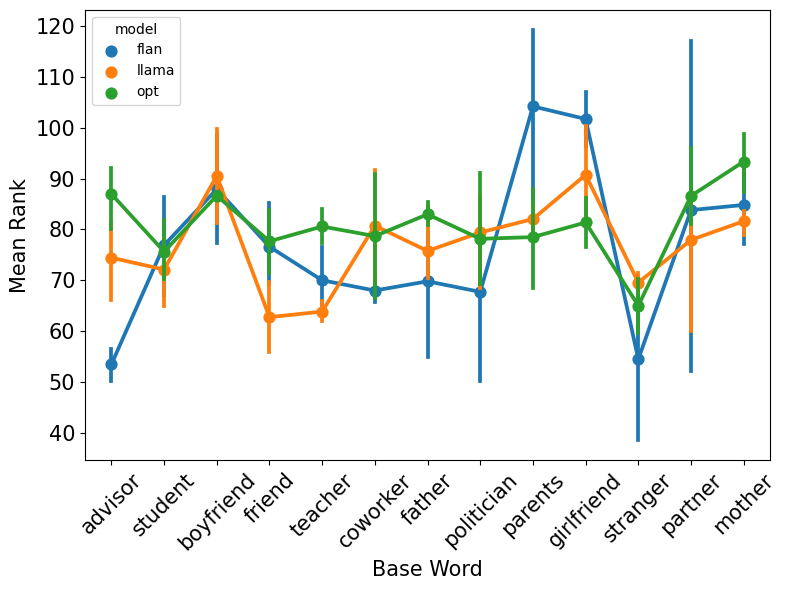

In [156]:
plot_hyponyms(mean_rank_per_role_model)

# Determining factors of model performance (figure 8)

## Frequency

In [178]:
# select answer results for questions in the test set
testset_df_dic = {}
for model_name, ans_df in model_ans_dic.items():
    testset_df_dic[model_name] = pd.merge(ans_df[['question', 'dataset', 'full_question', 'role', 'prompt', 'accuracy']], 
                                          test_ques_df[['question', 'dataset', 'full_question']], 
                                          how='right') 

In [242]:
testset_freq_dic = {}
models = ['flan', 'llama', 'opt']
for m in models:
    testset_df = testset_df_dic[m]
    role_dataset_acc_mean = testset_df.groupby(['dataset', 'role'])['accuracy'].mean().reset_index()
    role_dataset_acc_freq_merged = pd.merge(role_dataset_acc_mean, 
                                            role_df[['role','N-gram Frequency (2018-2019)', 'merged_cate']],
                                            how='left')
    test_freq = role_dataset_acc_freq_merged.groupby(['role','merged_cate'])[['accuracy', 'N-gram Frequency (2018-2019)']].mean().reset_index()
    test_freq['model'] = m
    testset_freq_dic[m] = test_freq


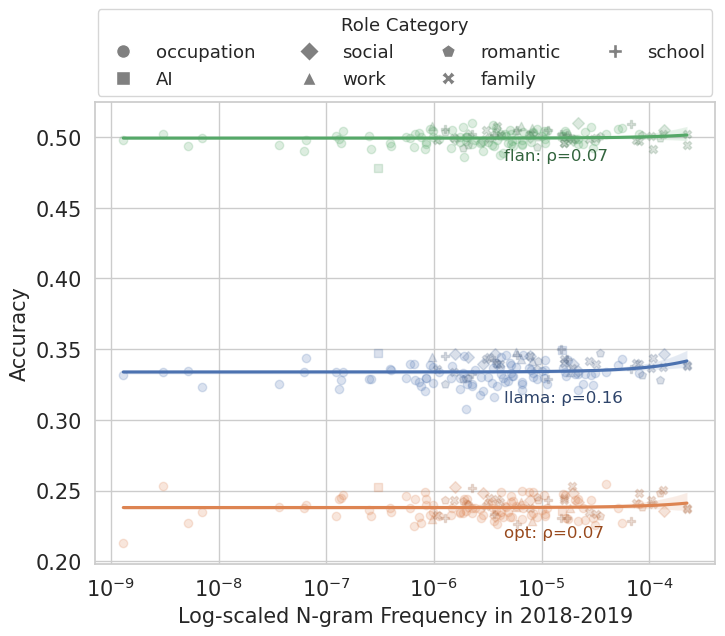

In [243]:
plot_test_acc_freq(testset_freq_dic)

## Perplexity

In [265]:
model_ans_dic['flan'].columns

Index(['full_prompt', 'full_question', 'role', 'merged_cate', 'answer',
       'prompt', 'question', 'option1', 'option2', 'option3', 'option4',
       'dataset', 'accuracy', 'domain', 'in_domain'],
      dtype='object')

In [297]:
# load ppl & accuracy dataframes 
testset_ppl_path_dic = {'flan': "../data/perplexity/flan_lmppl_testset_full.csv",
                        'llama': "../data/perplexity/llama_lmppl_testset_full_lm.csv",
                        'opt': "../data/perplexity/opt_lmppl_testset_full.csv"}

model_ppl_dic = {}
for m, ans_path in testset_ppl_path_dic.items():
    ppl_df = pd.read_csv(ans_path)
    ppl_var = f'prompt_ques_ppl_{m}'
    ppl_role_mean_df = ppl_df[['question', 'dataset', 'role','context_prompt', 'full_question', ppl_var, 'accuracy']].groupby(['role', 'dataset'])[[ppl_var, 'accuracy']].mean().reset_index()
    ppl_role_mean_df['model'] = m
    ppl_role_mean_df.rename(columns={ppl_var: 'ppl'}, inplace=True)
    ppl_role_mean_df = pd.merge(ppl_role_mean_df, role_df[['role', 'merged_cate']], how='left')
    
    model_ppl_dic[m] = {'ppl': ppl_df,
                       'role_mean': ppl_role_mean_df}
    

/tmp/ipykernel_1488078/360735267.py:7: DtypeWarning: Columns (13,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  ppl_df = pd.read_csv(ans_path)
/tmp/ipykernel_1488078/360735267.py:7: DtypeWarning: Columns (13,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  ppl_df = pd.read_csv(ans_path)
/tmp/ipykernel_1488078/360735267.py:7: DtypeWarning: Columns (13,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  ppl_df = pd.read_csv(ans_path)


In [256]:
# ppl_combined_role_cate = pd.read_csv("../data/perplexity/ppl_role_mean_all_models.csv")

In [298]:
model_ppl_dic['flan']['role_mean'].columns

Index(['role', 'dataset', 'ppl', 'accuracy', 'model', 'merged_cate'], dtype='object')

/tmp/ipykernel_1488078/2485024557.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tdf_role = tdf.groupby(['role','model']).mean().reset_index()


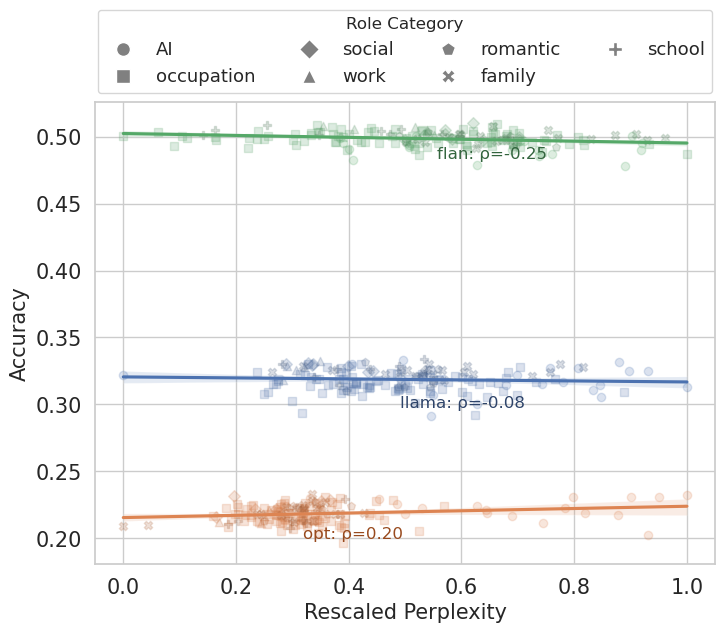

In [304]:
plot_test_acc_ppl(model_ppl_dic)

## Similarity

In [249]:
sim_testset = pd.read_csv("../data/testset_prompt_question_similarity.csv")

In [351]:
## these dataframes contain column "context_prompt" which is required for merging with similarity 
model_sim_dic = {}
for m, m_dic in model_ppl_dic.items():
    ans_df = m_dic['ppl'] # access the context prompt
    sim_df = pd.merge(sim_testset[['context_prompt', 'question','dataset','role','full_question', 'prompt_ques_sim']], 
                      ans_df[['context_prompt', 'question','dataset','role', 'accuracy']], 
                      how='left')
    sim_df = pd.merge(sim_df, role_df[['role', 'merged_cate']], how='left')
    
    sim_role_mean = sim_df.groupby(['role', 'dataset'])[['prompt_ques_sim', 'accuracy']].mean().reset_index()
    sim_role_mean = pd.merge(sim_role_mean, role_df[['role', 'merged_cate']], how='left')
    sim_role_mean['model'] = m 
    
    print(f"{m} done!")   
    model_sim_dic[m] = {'sim': sim_df,
                       'sim_role_mean': sim_role_mean}

flan done!
llama done!
opt done!


In [343]:
model_sim_dic['flan'].shape

(433836, 8)

In [342]:
model_sim_dic['flan'].columns

Index(['context_prompt', 'question', 'dataset', 'role', 'full_question',
       'prompt_ques_sim', 'accuracy', 'merged_cate'],
      dtype='object')

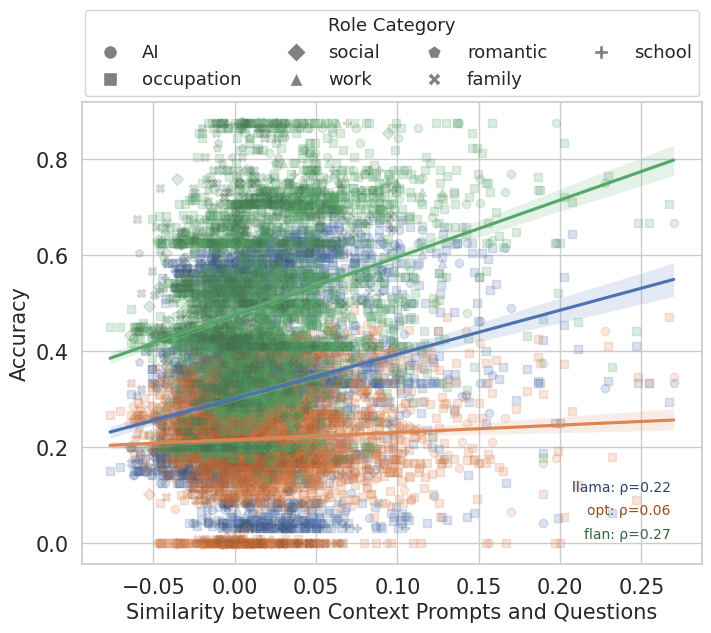

In [356]:
plot_test_acc_sim(model_sim_dic)

# Classification (figure 9-10)

In [376]:
trainset_df_dic = {}
for model_name, ans_df in model_ans_dic.items():
    trainset_df_dic[model_name] = pd.merge(ans_df[['question', 'dataset', 'full_question', 'role', 'merged_cate', 'prompt', 'accuracy']], 
                                          train_ques_df[['question', 'dataset', 'full_question']], 
                                          how='right') 
    

## best role per question (best role in testset)

In [454]:
best_per_question = {}
for m, test_df in testset_df_dic.items():
    role_mean = test_df.groupby(['role', 'full_question'])['accuracy'].mean().reset_index()
    best_role_idx = role_mean.groupby(['full_question'])['accuracy'].idxmax()
    best_role = role_mean.loc[best_role_idx].reset_index(drop=True)
    best_role.rename(columns={'accuracy': 'best_acc'}, inplace=True)
    
    best_per_question[m] = best_role

## best in-domain role

In [377]:
for m, train_df in trainset_df_dic.items():
    trainset_df_dic[m] = train_df.assign(domain=train_df['dataset'].apply(lambda x: find_domain(x)),
                                         in_domain=train_df.apply(lambda row: 1 if find_domain(row['dataset']) == row['merged_cate'] else 0, axis=1))

In [476]:
best_indomain = {}
for m, train_df in trainset_df_dic.items():
    train_indomain = train_df[train_df['in_domain'] == 1]
    role_mean = train_indomain.groupby(['dataset','role'])['accuracy'].mean().reset_index()
    
    # find the best in-domain role for each dataset
    best_role_idx = role_mean.groupby(['dataset'])['accuracy'].idxmax()
    best_indomain_role = role_mean.loc[best_role_idx].reset_index(drop=True)
    best_role_ = pd.merge(test_ques_df[['full_question', 'dataset']],
                         best_indomain_role[['dataset', 'role']],
                         how='left')
    
    # map the best indomain role's performance on the testset 
    test_role_dataset_mean = testset_df_dic[m].groupby(['dataset', 'role'])['accuracy'].mean().reset_index()
    best_indomain_on_testset = pd.merge(best_role_,
                                        test_role_dataset_mean,
                                        how='left')
    best_indomain_on_testset.rename(columns={'accuracy': 'best_in-domain_acc'}, inplace=True)

    best_indomain[m] = {'train_indomain_role_mean': role_mean,
                       'best_indomain_role': best_indomain_role,
                       'testset_result': best_indomain_on_testset}

In [477]:
best_indomain['llama']['testset_result']

,full_question,dataset,role,best_in-domain_acc
0,Why would you need to carry out a bladder wash...,clinical_knowledge,dentist,0.357143
1,Which of the following is true of calcium meta...,clinical_knowledge,dentist,0.357143
2,Which of the following best describes the effe...,clinical_knowledge,dentist,0.357143
3,Name the bones of the middle finger in the cor...,clinical_knowledge,dentist,0.357143
4,Wound drainage should be assessed for volume a...,clinical_knowledge,dentist,0.357143
...,...,...,...,...
458,Which of these is not a component of the 'Amer...,us_foreign_policy,politician,0.644444
459,"During the early years of his administration, ...",us_foreign_policy,politician,0.644444
460,Global and regional international trade agreem...,us_foreign_policy,politician,0.644444
461,Why did Lincoln oppose the southward expansion...,us_foreign_policy,politician,0.644444


## most similar role

In [390]:
testset_sim_result.columns

Index(['role', 'prompt', 'context_prompt', 'full_question', 'prompt_ques_sim'], dtype='object')

In [455]:
test_most_sim_role = {}
for m, test_df in testset_df_dic.items():
    sim_role = pd.merge(testset_sim_result[['context_prompt', 'full_question','role', 'prompt_ques_sim']],
                        test_df[['full_question','dataset','role', 'prompt','accuracy']], how='right')
    sim_role_mean = sim_role.groupby(['role', 'full_question'])['prompt_ques_sim'].mean().reset_index()
    sim_role_best_idx = sim_role_mean.groupby(['full_question'])['prompt_ques_sim'].idxmax()
    sim_role_best = sim_role_mean.loc[sim_role_best_idx].reset_index(drop=True)
    
    # map question to dataset 
    tdf = pd.merge(sim_role_best[['full_question', 'role']], 
                   test_ques_df[['full_question', 'dataset']], 
                   on='full_question', 
                   how='left')

    # map the best indomain role's performance on the testset
    test_role_dataset_mean = test_df.groupby(['dataset', 'role'])['accuracy'].mean().reset_index()
    most_sim_role = pd.merge(tdf, test_role_dataset_mean, how='left')
    
    most_sim_role.rename(columns={'accuracy': 'most_sim_acc'}, inplace=True)
    
    test_most_sim_role[m] = most_sim_role

## dataset prediction

In [414]:
train_set_results = {}
for m, train_df in trainset_df_dic.items():
    role_dataset_mean = train_df.groupby(['dataset', 'role'])['accuracy'].mean().reset_index()
    dataset_best_role_idx = role_dataset_mean.groupby('dataset')['accuracy'].idxmax()
    dataset_best_role = role_dataset_mean.loc[dataset_best_role_idx].reset_index(drop=True)
    train_set_results[m] = {'role_dataset_mean': role_dataset_mean,
                           'dataset_best_role': dataset_best_role[['dataset', 'role']]}

In [407]:
dataset_classification = pd.read_csv("../data/classification/dataset_pred_result.csv")

In [408]:
dataset_classification.head()

,text,true_labels,predicted_labels,predicted_dataset,true_dataset,true
0,Why would you need to carry out a bladder wash...,0,0,clinical_knowledge,clinical_knowledge,1
1,Which of the following is true of calcium meta...,0,5,college_medicine,clinical_knowledge,0
2,Which of the following best describes the effe...,0,0,clinical_knowledge,clinical_knowledge,1
3,Name the bones of the middle finger in the cor...,0,0,clinical_knowledge,clinical_knowledge,1
4,Wound drainage should be assessed for volume a...,0,0,clinical_knowledge,clinical_knowledge,1


In [409]:
dataset_classification.rename(columns={'text':'full_question'}, inplace=True)

In [456]:
dataset_pred_role = {}
for m, train_result in train_set_results.items():
    test_role_dataset_mean = testset_df_dic[m].groupby(['dataset', 'role'])['accuracy'].mean().reset_index()
    dataset_pred_acc = pd.merge(train_result['dataset_best_role'], 
                                test_role_dataset_mean, how='left')
    
    # map predicted_dataset to its best in-domain role in the training data 
    dataset_pred_ques_role = pd.merge(dataset_classification[['full_question', 'predicted_dataset']],
                                      best_indomain[m]['best_indomain_role'][['dataset', 'role']],
                                      how='left', left_on='predicted_dataset', right_on='dataset')
    
    # map the best in-domain role to its actual accuracy in the test set 
    dataset_pred_ques_result = pd.merge(dataset_pred_ques_role,
                                        test_role_dataset_mean, how='left')
    dataset_pred_ques_result.rename(columns={'accuracy': 'pred_best_indomain_acc'}, inplace=True)
    
    dataset_pred_role[m] = dataset_pred_ques_result

## role prediction

In [423]:
def string_to_list_of_ints(s):
    cleaned = s.replace("[", "").replace("]", "").replace("\n", "")
    return [float(x) for x in cleaned.split()]

In [428]:
'''PROCESS RAW RESULT'''
# flan_role_pred_raw = pd.read_csv('../roberta-base-role-classifier-full-question-flan/flan_role_pred.csv')
# flan_role_pred_truth = pd.read_csv('../data/flan_role_class_agg_prompt_data.csv')
# flan_role_idx = pd.read_csv('../shared_data/role_index_classifier_flan.csv')

# flan_role_pred_merged = pd.merge(flan_role_pred_raw,
#                                  flan_role_pred_truth[['full_question', 'dataset']],
#                                  left_on="text", right_on="full_question", how="left")

# flan_role_pred_merged['predicted_labels'] = flan_role_pred_merged['predicted_labels'].apply(string_to_list_of_ints)
# flan_role_pred_merged.drop('text', axis=1, inplace=True)

# flan_role_pred_merged['max_index'] = flan_role_pred_merged['predicted_labels'].apply(lambda x: x.index(max(x)))
# flan_role_pred_merged['max_role'] = flan_role_pred_merged['max_index'].map(flan_role_idx.set_index('index')['role'])
# flan_role_pred_merged.drop('max_index', axis=1, inplace=True)
# flan_role_pred_merged.rename(columns={'max_role': 'role'}, inplace=True)

In [432]:
role_pred_result_path = {'flan': "../data/classification/role_pred_flan.csv",
                        'llama': "../data/classification/role_pred_llama.csv"}

In [457]:
role_pred_result = {}
for m, path in role_pred_result_path.items():
    role_pred_raw = pd.read_csv(path)
    test_role_dataset_mean = testset_df_dic[m].groupby(['dataset', 'role'])['accuracy'].mean().reset_index()
    role_pred_acc = pd.merge(role_pred_raw,
                             test_role_dataset_mean,
                             how='left')
    role_pred_acc.rename(columns={'accuracy': 'pred_role_acc'}, inplace=True)
    
    role_pred_result[m] = {'raw_result': role_pred_raw,
                          'role_pred_acc': role_pred_acc}

In [458]:
role_pred_result['llama']['role_pred_acc'].head() # same as before

,true_labels,predicted_labels,full_question,dataset,role,pred_role_acc
0,[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,"[0.7510522, 0.7469741, 0.7417616, 0.7588723, 0...","""The basic premise of the “Zeigarnik effect"""" ...",professional_psychology,student,0.518519
1,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"[0.08772036, 0.10265307, 0.08334701, 0.0927680...","A 14-year-old girl has had nausea, intermitten...",professional_medicine,Mathematical Modeling AI,0.125000
2,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"[0.5064239, 0.5177552, 0.475726, 0.5230452, 0....",A 15-year-old male is brought to the office wi...,professional_medicine,blacksmith,0.187500
3,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"[0.45093444, 0.43880138, 0.40867534, 0.44819, ...",A 2008 survey of 500 households concluded that...,high_school_statistics,student,0.047619
4,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"[0.1817821, 0.20192747, 0.17311226, 0.19937065...",A 25 g sample of a liquid was heated to 100 °C...,high_school_chemistry,Mathematical Modeling AI,0.214286


## best on training set

In [446]:
trainset_df_dic['flan'].groupby('role')['accuracy'].mean().sort_values(ascending=False).reset_index().loc[0]

role          police
accuracy    0.483008
Name: 0, dtype: object

In [444]:
trainset_df_dic['llama'].groupby('role')['accuracy'].mean().sort_values(ascending=False).reset_index().loc[0]

role        AI language model
accuracy             0.394376
Name: 0, dtype: object

In [459]:
best_role_in_train = {}

for m, train_df in trainset_df_dic.items():
    role = train_df.groupby('role')['accuracy'].mean().sort_values(ascending=False).reset_index().loc[0]['role']
    test_role_dataset_mean = testset_df_dic[m].groupby(['dataset', 'role'])['accuracy'].mean().reset_index()
    best_role_acc = test_role_dataset_mean[test_role_dataset_mean['role'] == 'police']
    train_best_role = pd.merge(test_ques_df, best_role_acc, how='left')
    train_best_role.rename(columns={'accuracy': 'train_best_role_acc'}, inplace=True)
    best_role_in_train[m] = train_best_role

## random baseline

In [530]:
def random_baseline_acc(test_ques_df, test_role_ques_mean, n_iterations=5):
    cumulative_accuracy_df = pd.DataFrame()
    roles = flan_role_idx['role'].tolist()
    np.random.seed(43)

    for _ in range(n_iterations):
        # Random role assignment
        random_df = test_ques_df.copy()
        random_df['role'] = np.random.choice(roles, size=len(random_df))

        # Merge with the mean accuracy DataFrame
        ques_random_df = pd.merge(
            random_df[['full_question', 'role', 'question']],
            test_role_ques_mean[['full_question', 'role', 'accuracy']],
            how='left'
        )

        # If this is the first iteration, initialize cumulative_accuracy_df
        if cumulative_accuracy_df.empty:
            cumulative_accuracy_df = ques_random_df[['full_question', 'accuracy']].copy()
            cumulative_accuracy_df.rename(columns={'accuracy': 'cumulative_accuracy'}, inplace=True)
        else:
            # Add the accuracy of this iteration to the cumulative accuracy
            cumulative_accuracy_df['cumulative_accuracy'] += ques_random_df['accuracy']

    cumulative_accuracy_df['average_accuracy'] = cumulative_accuracy_df['cumulative_accuracy'] / n_iterations
    cumulative_accuracy_df.rename(columns={'average_accuracy': 'random_baseline'}, inplace=True)
    return cumulative_accuracy_df

In [531]:
random_dic = {}
models = ['flan', 'llama']
for m, test in testset_df_dic.items():
    random_dic[m] = random_baseline_acc(test_ques_df, 
                                        test.groupby(['role', 'full_question'])['accuracy'].mean().reset_index())

In [532]:
random_dic['flan'].columns

Index(['full_question', 'cumulative_accuracy', 'random_baseline'], dtype='object')

## testset control

In [483]:
test_ctrl_dic = {}
for m, ctrl in model_ctrl_dic.items():
    test_ctrl_dic[m] = pd.merge(test_ques_df, ctrl, how='left')
    test_ctrl_dic[m].rename(columns={'accuracy':'control'}, inplace=True)

## results for automatic role picking

In [487]:
from functools import reduce

In [543]:
models = ['flan', 'llama']

role_pick_result_all = {}
for m in models:
    ctrl = test_ctrl_dic[m][['full_question', 'control']]
    best_role = best_per_question[m][['full_question', 'best_acc']]
    best_indomain_role = best_indomain[m]['testset_result'][['full_question', 'best_in-domain_acc']]
    most_sim = test_most_sim_role[m][['full_question', 'most_sim_acc']]
    dataset_pred = dataset_pred_role[m][['full_question', 'pred_best_indomain_acc']]
    role_pred = role_pred_result[m]['role_pred_acc'][['full_question', 'pred_role_acc']]
    best_train = best_role_in_train[m][['full_question', 'train_best_role_acc']]
    random_baseline = random_dic[m][['full_question', 'random_baseline']]
    
    dfs = [ctrl, best_role, best_indomain_role, most_sim, dataset_pred, role_pred, best_train, random_baseline]
    merged_df = reduce(lambda left, right: pd.merge(left, right, on=['full_question']), dfs)
    role_pick_result_all[m] = merged_df

In [544]:
role_pick_result_all['llama'].columns

Index(['full_question', 'control', 'best_acc', 'best_in-domain_acc',
       'most_sim_acc', 'pred_best_indomain_acc', 'pred_role_acc',
       'train_best_role_acc', 'random_baseline'],
      dtype='object')

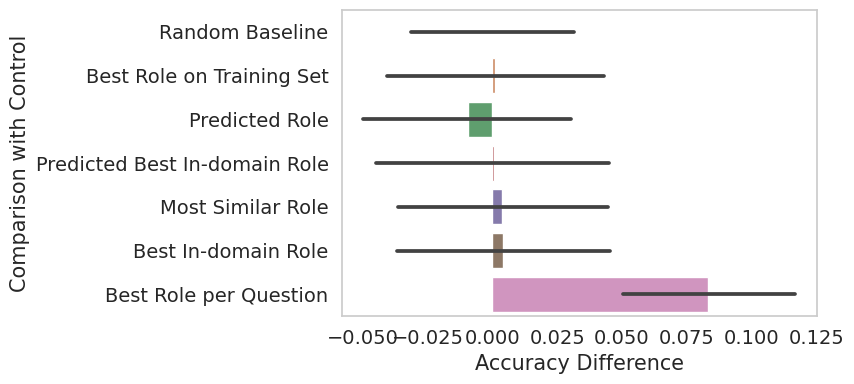

In [549]:
tdf = role_pick_result_all['flan']
plot_role_pick(tdf)

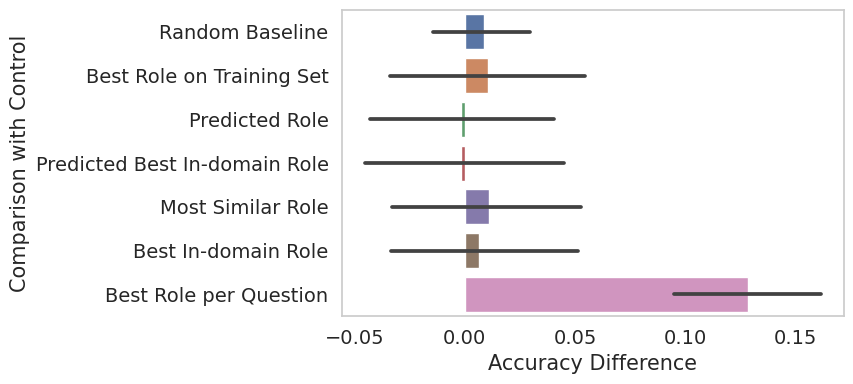

In [550]:
tdf = role_pick_result_all['llama']
plot_role_pick(tdf)